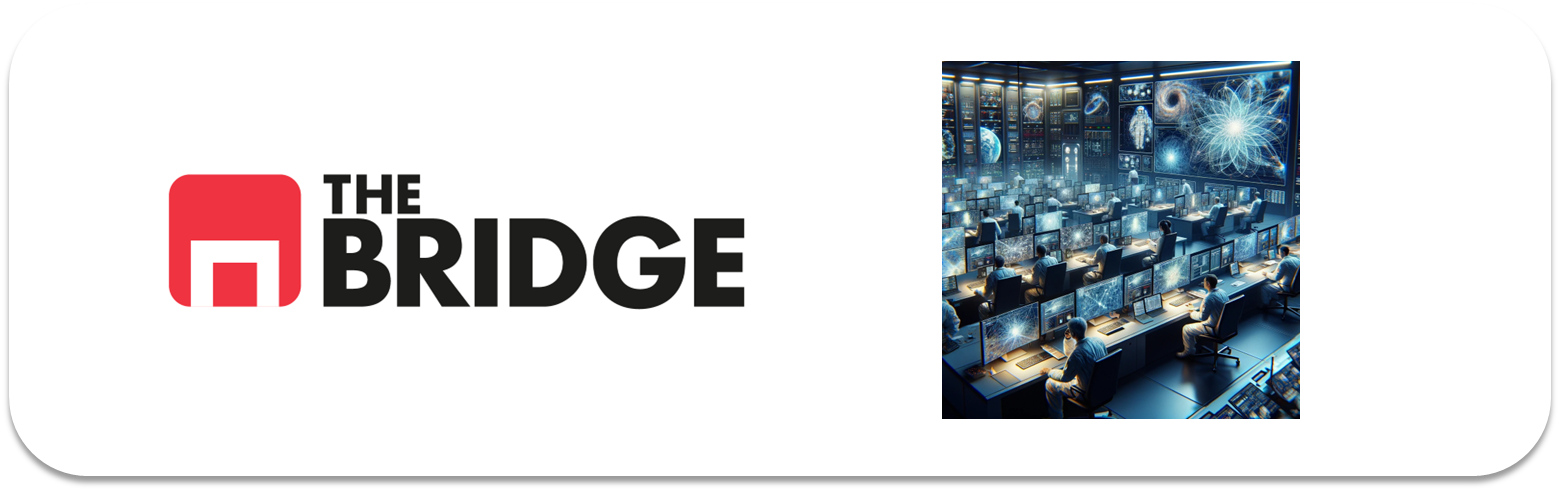

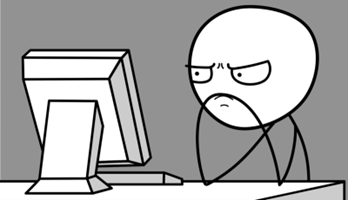

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitar√°s datos que est√°n en el directorio data que acompa√±a al notebook (b√∫scalo en el repositorio de ejercicios)
  
La soluci√≥n a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y m√≥dulos que necesites a lo largo del notebook

In [1]:
import pandas as pd
import numpy as np

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de im√°genes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 im√°genes por cada tipo. Tendr√°s que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificaci√≥n de una menor cantidad de casos (s√≥lo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribuci√≥n, para ello tendr√°s que explorar las estructura. Crea un juego Train,test para resoluci√≥n 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorio donde se encuentran las im√°genes de manzanas
DATASET_PATH = "./data/apples" 

# Par√°metros
IMG_SIZE_SMALL = (32, 32)
IMG_SIZE_LARGE = (224, 224)
BATCH_SIZE = 32

# Definir los generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalizaci√≥n
test_datagen = ImageDataGenerator(rescale=1./255)  

# Directorios de im√°genes
train_dir = "data/apples/train"
test_dir = "data/apples/test"

# Tama√±o de imagen 32x32
image_size = (32, 32)
batch_size = 32  # Puedes ajustar seg√∫n la memoria disponible

# Generadores de im√°genes
train_generator_32 = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",  # Asegura que la salida sea one-hot encoding
    shuffle=True
)

test_generator_32 = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # No mezclamos test para evaluaci√≥n clara
)


# Obtener X_train, y_train de train_generator_32
X_train, y_train = next(train_generator_32)
X_test_32, y_test_32 = next(test_generator_32)

# Verificar dimensiones
print(f"X_train shape: {X_train.shape}")
print(f"X_test_32 shape: {X_test_32.shape}")


Found 6404 images belonging to 13 classes.
Found 2134 images belonging to 13 classes.
X_train shape: (32, 32, 32, 3)
X_test_32 shape: (32, 32, 32, 3)


**NOTA:** A partir de aqu√≠ emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualizaci√≥n de algunos de los datos. Crea una funci√≥n que te ayude con ello.

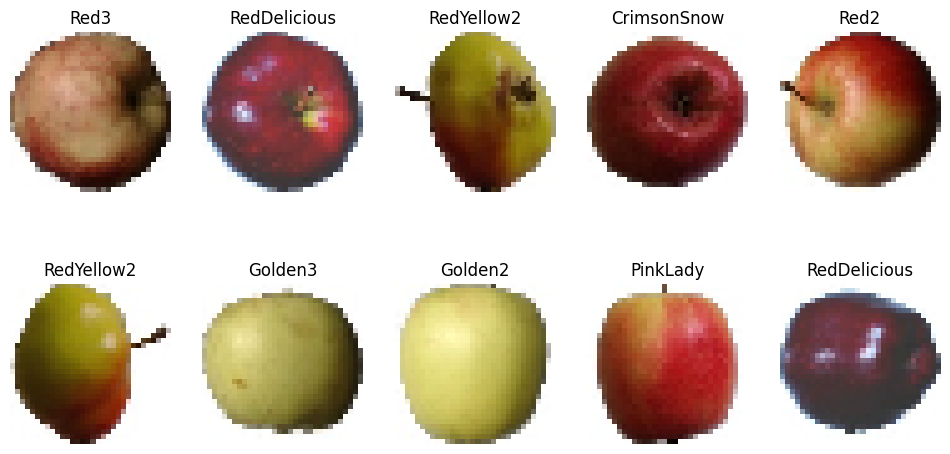

In [28]:
import matplotlib.pyplot as plt

def visualizar_imagenes(X, y, class_labels, num_images=10):
    """
    Muestra una serie de im√°genes con sus etiquetas.

    Par√°metros:
    - X: array de im√°genes.
    - y: etiquetas en one-hot encoding.
    - class_labels: lista de nombres de las clases.
    - num_images: cantidad de im√°genes a mostrar.
    """
    plt.figure(figsize=(12, 6))
    indices = np.random.choice(len(X), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[idx])
        plt.title(class_labels[np.argmax(y[idx])])
        plt.axis("off")

    plt.show()

# Obtener etiquetas de las clases
class_labels = list(train_generator_32.class_indices.keys())

# Visualizar im√°genes del conjunto de entrenamiento
visualizar_imagenes(X_train, y_train, class_labels)


### Ejercicio 3

Completa el miniEDA habitual con im√°genes y escoge una m√©trica para el modelo.

/var/folders/lc/xsbjt6rs2gq59y6tqrhdjzb40000gn/T/ipykernel_13750/3612473253.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Clase", y="Cantidad", data=class_distribution, palette="viridis")


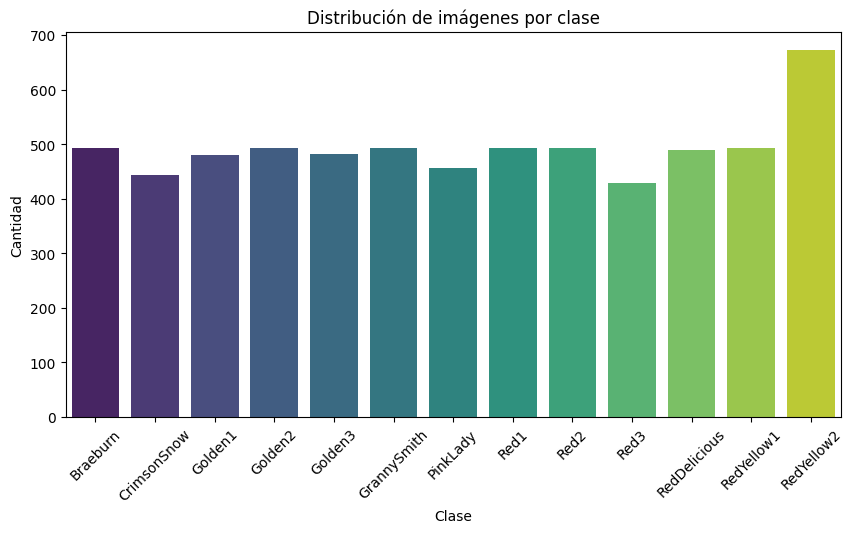

Total im√°genes en Train: 6404
Total im√°genes en Test: 2134


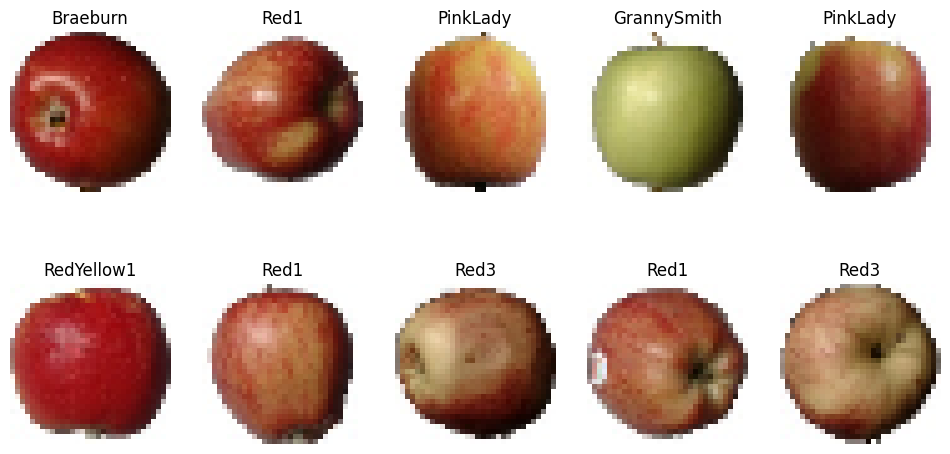

In [6]:
import seaborn as sns

# Obtener el n√∫mero de im√°genes por clase
class_counts = {k: v for k, v in train_generator_32.class_indices.items()}
class_distribution = pd.DataFrame({
    "Clase": list(class_counts.keys()),
    "Cantidad": [train_generator_32.classes.tolist().count(v) for v in class_counts.values()]
})

# üìä 1. Distribuci√≥n de clases
plt.figure(figsize=(10, 5))
sns.barplot(x="Clase", y="Cantidad", data=class_distribution, palette="viridis")
plt.xticks(rotation=45)
plt.title("Distribuci√≥n de im√°genes por clase")
plt.show()

# üìå 2. Estad√≠sticas b√°sicas
print(f"Total im√°genes en Train: {train_generator_32.samples}")
print(f"Total im√°genes en Test: {test_generator_32.samples}")

# üì∏ 3. Visualizaci√≥n de im√°genes (usando la funci√≥n anterior)
visualizar_imagenes(X_train, y_train, class_labels)


### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la funci√≥n shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [11]:
from sklearn.utils import shuffle

# Barajar X_train y y_train sin modificar los originales
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

# Verificar que se barajaron correctamente
print("Datos barajados correctamente.")


Datos barajados correctamente.


### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a num√©ricas, creando dos diccionarios uno que permita traducir de etiqueta a clase num√©rica y otro que permita la transformaci√≥n inversa.

In [12]:
# Obtener el mapeo de clases detectadas por ImageDataGenerator
label_to_index = train_generator_32.class_indices  # {'Fuji': 0, 'Gala': 1, 'Golden': 2, ...}

# Crear el diccionario inverso para convertir de n√∫mero a texto
index_to_label = {v: k for k, v in label_to_index.items()}

# Verificar que los diccionarios son correctos
print("Diccionario de etiquetas a n√∫meros:", label_to_index)
print("Diccionario inverso (n√∫meros a etiquetas):", index_to_label)


Diccionario de etiquetas a n√∫meros: {'Braeburn': 0, 'CrimsonSnow': 1, 'Golden1': 2, 'Golden2': 3, 'Golden3': 4, 'GrannySmith': 5, 'PinkLady': 6, 'Red1': 7, 'Red2': 8, 'Red3': 9, 'RedDelicious': 10, 'RedYellow1': 11, 'RedYellow2': 12}
Diccionario inverso (n√∫meros a etiquetas): {0: 'Braeburn', 1: 'CrimsonSnow', 2: 'Golden1', 3: 'Golden2', 4: 'Golden3', 5: 'GrannySmith', 6: 'PinkLady', 7: 'Red1', 8: 'Red2', 9: 'Red3', 10: 'RedDelicious', 11: 'RedYellow1', 12: 'RedYellow2'}


### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pru√©balo contra el test (aqu√≠ no valen nuestras categor√≠as ser√°n las que proporcione ResNet ojo). Prueba una selecci√≥n aleatoria de im√°genes del test y compara las etiquetas de ResNet con la que tiene. ¬øNos sirve este clasificador as√≠ tal cual?

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import random
import matplotlib.pyplot as plt

# Cargar el modelo ResNet50 con pesos de ImageNet
resnet_model = ResNet50(weights="imagenet")


102967424/102967424 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 0us/step


In [16]:
def predecir_con_resnet(img_path):
    """
    Carga una imagen, la procesa para ResNet50 y obtiene las predicciones del modelo.
    """
    # Cargar imagen y ajustar tama√±o a 224x224 para ResNet
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expandir dimensiones para el modelo
    img_array = preprocess_input(img_array)  # Preprocesamiento para ResNet

    # Hacer la predicci√≥n
    preds = resnet_model.predict(img_array)

    # Decodificar las 3 predicciones m√°s probables
    decoded_preds = decode_predictions(preds, top=3)[0]
    
    return img, decoded_preds


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 775ms/step
1. maraca (27.85%)
2. punching_bag (17.10%)
3. gong (9.89%)


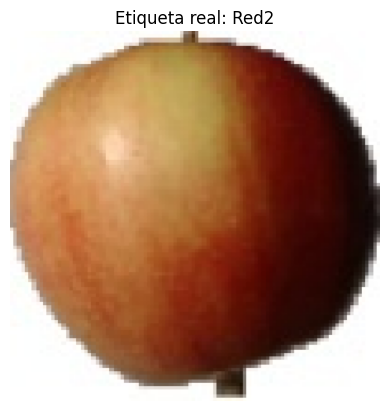

In [ ]:

# Obtener im√°genes aleatorias del test
test_dir = "./data/apples/test"
random_class = random.choice(os.listdir(test_dir))  # Elegimos una variedad de manzana aleatoria
random_image = random.choice(os.listdir(os.path.join(test_dir, random_class)))  # Elegimos una imagen

# Obtener ruta completa de la imagen
img_path = os.path.join(test_dir, random_class, random_image)

# Predecir con ResNet
img, preds = predecir_con_resnet(img_path)

# Mostrar la imagen con las predicciones
plt.imshow(img)
plt.axis("off")
plt.title(f"Etiqueta real: {random_class}")

# Mostrar las predicciones de ResNet
for i, (imagenet_id, label, prob) in enumerate(preds):
    print(f"{i+1}. {label} ({prob:.2%})")


## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activaci√≥n "relu") y otra de salida con las unidades que crees necesarias y activaci√≥n la que consideres. Congela las capas del modelo base (la ResNet50). Define tambi√©n los hiperpar√°metros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Cargar ResNet50 sin la cabeza
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas de la base (ResNet50)
for layer in base_model.layers:
    layer.trainable = False

# A√±adir la cabeza personalizada
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Capa de pooling global para reducir las dimensiones
x = Dense(300, activation='relu')(x)  # Capa densa oculta con 300 unidades y activaci√≥n ReLU
x = Dense(len(class_labels), activation='softmax')(x)  # Capa de salida con el n√∫mero de clases y activaci√≥n softmax

# Definir el modelo completo
model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),  # Optimizaci√≥n con Adam y una tasa de aprendizaje peque√±a
              loss='categorical_crossentropy',  # Para clasificaci√≥n m√∫ltiple, usamos categorical crossentropy
              metrics=['accuracy'])  # M√©trica de precisi√≥n

# Mostrar el resumen del modelo
model.summary()


94765736/94765736 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 0us/step


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_1       ‚îÇ (None, 224, 224,  ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ 3)                ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_pad           ‚îÇ (None, 230, 230,  ‚îÇ          0 ‚îÇ input_layer_1[0]‚Ä¶ ‚îÇ
‚îÇ (ZeroPadding2D)     ‚îÇ 3)                ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_conv (Conv2D) ‚îÇ (None, 112, 112,  ‚îÇ      9,472 ‚îÇ conv1_pad[0][0]   ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_bn            ‚îÇ (None, 112, 112,  ‚îÇ        256 ‚îÇ conv1_conv[0][0]  ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_relu          ‚îÇ (None, 112, 112,  ‚îÇ          0 ‚îÇ conv1_bn[0][0]    ‚îÇ
‚îÇ (Activation)        ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ pool1_pad           ‚îÇ (None, 114, 114,  ‚îÇ          0 ‚îÇ conv1_relu[0][0]  ‚îÇ
‚îÇ (ZeroPadding2D)     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ pool1_pool          ‚îÇ (None, 56, 56,    ‚îÇ          0 ‚îÇ pool1_pad[0][0]   ‚îÇ
‚îÇ (MaxPooling2D)      ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2_block1_1_conv ‚îÇ (None, 56, 56,    ‚îÇ      4,160 ‚îÇ pool1_pool[0][0]  ‚îÇ
‚îÇ (Conv2D)            ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2_block1_1_bn   ‚îÇ (None, 56, 56,    ‚îÇ        256 ‚îÇ conv2_block1_1_c‚Ä¶ ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 24,206,325 (92.34 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evoluci√≥n del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el n√∫mero de √©pocas.

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Definir los generadores con im√°genes redimensionadas a 224x224
train_generator_224 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Aseg√∫rate de usar 224x224
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_generator_224 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Aseg√∫rate de usar 224x224
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Cargar ResNet50 sin las cabezas finales
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas base
base_model.trainable = False

# A√±adir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(300, activation='relu')(x)
x = Dense(len(class_labels), activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Configurar par√°metros
batch_size = 32  
epochs = 50  

# Callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,  
                               restore_best_weights=True, 
                               verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator_224,  
    epochs=epochs,
    validation_data=test_generator_224,  
    callbacks=[early_stopping],
)

# Mostrar la evoluci√≥n del entrenamiento (precisi√≥n y p√©rdida)
plt.figure(figsize=(12, 5))

# Gr√°fico de precisi√≥n
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title('Evoluci√≥n de la precisi√≥n')
plt.xlabel('√âpocas')
plt.ylabel('Precisi√≥n')
plt.legend()

# Gr√°fico de p√©rdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title('Evoluci√≥n de la p√©rdida')
plt.xlabel('√âpocas')
plt.ylabel('P√©rdida')
plt.legend()

plt.show()

Found 6404 images belonging to 13 classes.
Found 2134 images belonging to 13 classes.
Epoch 1/50
 45/201 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2:29 958ms/step - accuracy: 0.0824 - loss: 2.6703

KeyboardInterrupt: 

In [21]:
# Tama√±o de imagen 224x224
image_size = IMG_SIZE_LARGE  # Cambia a 224x224

# Generadores de im√°genes con tama√±o 224x224
train_generator_224 = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,  # Cambia aqu√≠ el tama√±o de la imagen
    batch_size=batch_size,
    class_mode="categorical",  # Asegura que la salida sea one-hot encoding
    shuffle=True
)

test_generator_224 = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,  # Cambia aqu√≠ el tama√±o de la imagen
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # No mezclamos test para evaluaci√≥n clara
)


Found 6404 images belonging to 13 classes.
Found 2134 images belonging to 13 classes.


### Ejercicio 9

Evalua el modelo contra test y haz un peque√±o an√°lisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un peque√±o an√°lisis de errores.

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

### Ejercicio 11
Entrena con batch_size a 64 y 60 √©pocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente m√°s largo, as√≠ que t√≥mate un descanso). Muestra la evoluci√≥n y da una posible justificaci√≥n a emplear tantas √©pocas de partida.

### Ejercicio 12

Muestra la evaluaci√≥n contra el test, el informe de clasificaci√≥n  y la matriz de confusi√≥n. Compara los resultados con los del ejercicio 9.